# Overview

### Target 
1. Since we are almost at 10,000 parameters, we dont want to increase the number of layers but play around with the number of channels and add another convolutional layer, transition block, FC layer followed by at GAP to allow this.

### Result 
1. Parameters: 8,870
2. Best Training Accuracy: 99.07
3. Best Test Accuracy: 99.38

### Analysis 
1. Training is noisy


# Import Libraries

In [42]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [43]:
import matplotlib.pyplot as plt

# Data Transformations


In [44]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [45]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [46]:
SEED = 1

cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Model


In [47]:
dropout_value = 0.1
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()

    # Convolution Block 1
    self.convblock1 = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=10,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(10),nn.Dropout(dropout_value)
    )

    # Convolution Block 2
    self.convblock2 = nn.Sequential(
        nn.Conv2d(in_channels=10,out_channels=20,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(20),nn.Dropout(dropout_value)
    )

    # Transition Block 1
    self.transblock1 = nn.Sequential(
        nn.Conv2d(in_channels=20,out_channels=10,kernel_size=(1,1),padding = 0, bias = False),
        nn.MaxPool2d(2, 2), 
    )

    # Convolution Block 3
    self.convblock3 = nn.Sequential(
        nn.Conv2d(in_channels=10,out_channels=20,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(20),nn.Dropout(dropout_value)
    )

    # Convolution Block 4
    self.convblock4 = nn.Sequential(
        nn.Conv2d(in_channels=20,out_channels=10,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(10),nn.Dropout(dropout_value)
    )

    # Convolution Block 5
    self.convblock5 = nn.Sequential(
        nn.Conv2d(in_channels=10,out_channels=10,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(10),nn.Dropout(dropout_value)
    )

    self.convblock6 = nn.Sequential(
        nn.Conv2d(in_channels=10,out_channels=20,kernel_size=(3,3),padding = 1, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(20),nn.Dropout(dropout_value)
    )


    # Global average pooling layer
    self.gap = nn.Sequential(
        nn.AvgPool2d(kernel_size=6),
        nn.Conv2d(in_channels=20,out_channels=10,kernel_size=(1,1),padding = 0, bias = False)
    )

    self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) 

  
  def forward(self, x):

    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.transblock1(x)

    x = self.convblock3(x)
    x = self.convblock4(x)    
    x = self.convblock5(x)
    x = self.convblock6(x)
 
    x = self.gap(x)
    x = self.convblock7(x)
    x = x.view(-1,10)
    
    return F.log_softmax(x,dim = -1)


# Model Parameters

In [48]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
       BatchNorm2d-7           [-1, 20, 24, 24]              40
           Dropout-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             200
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 20, 10, 10]           1,800
             ReLU-12           [-1, 20, 10, 10]               0
      BatchNorm2d-13           [-1, 20, 10, 10]              40
          Dropout-14           [-1

# Training and Testing

In [49]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  
  train_losses.append(loss)
  train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [50]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.08990976214408875 Batch_id=468 Accuracy=80.49: 100%|██████████| 469/469 [00:20<00:00, 22.66it/s]



Test set: Average loss: 0.0981, Accuracy: 9714/10000 (97.14%)

EPOCH: 1


Loss=0.08811218291521072 Batch_id=468 Accuracy=96.77: 100%|██████████| 469/469 [00:20<00:00, 22.71it/s]



Test set: Average loss: 0.0589, Accuracy: 9811/10000 (98.11%)

EPOCH: 2


Loss=0.08739890903234482 Batch_id=468 Accuracy=97.55: 100%|██████████| 469/469 [00:20<00:00, 22.70it/s]



Test set: Average loss: 0.0437, Accuracy: 9865/10000 (98.65%)

EPOCH: 3


Loss=0.011513824574649334 Batch_id=468 Accuracy=97.93: 100%|██████████| 469/469 [00:20<00:00, 22.54it/s]



Test set: Average loss: 0.0392, Accuracy: 9878/10000 (98.78%)

EPOCH: 4


Loss=0.027462951838970184 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:20<00:00, 22.43it/s]



Test set: Average loss: 0.0362, Accuracy: 9901/10000 (99.01%)

EPOCH: 5


Loss=0.10839789360761642 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:21<00:00, 22.18it/s]



Test set: Average loss: 0.0360, Accuracy: 9893/10000 (98.93%)

EPOCH: 6


Loss=0.07476900517940521 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:20<00:00, 22.45it/s]



Test set: Average loss: 0.0302, Accuracy: 9907/10000 (99.07%)

EPOCH: 7


Loss=0.004521436523646116 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:21<00:00, 22.14it/s]



Test set: Average loss: 0.0281, Accuracy: 9907/10000 (99.07%)

EPOCH: 8


Loss=0.01448915433138609 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:21<00:00, 22.22it/s]



Test set: Average loss: 0.0274, Accuracy: 9918/10000 (99.18%)

EPOCH: 9


Loss=0.007396211382001638 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:20<00:00, 22.62it/s]



Test set: Average loss: 0.0295, Accuracy: 9908/10000 (99.08%)

EPOCH: 10


Loss=0.07120541483163834 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:20<00:00, 22.34it/s]



Test set: Average loss: 0.0236, Accuracy: 9923/10000 (99.23%)

EPOCH: 11


Loss=0.04456845298409462 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:21<00:00, 22.25it/s]



Test set: Average loss: 0.0211, Accuracy: 9942/10000 (99.42%)

EPOCH: 12


Loss=0.016933124512434006 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:20<00:00, 22.35it/s]



Test set: Average loss: 0.0227, Accuracy: 9930/10000 (99.30%)

EPOCH: 13


Loss=0.006146672647446394 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:21<00:00, 22.29it/s]



Test set: Average loss: 0.0235, Accuracy: 9930/10000 (99.30%)

EPOCH: 14


Loss=0.016179798170924187 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:21<00:00, 22.30it/s]



Test set: Average loss: 0.0229, Accuracy: 9927/10000 (99.27%)

EPOCH: 15


Loss=0.025814203545451164 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:21<00:00, 22.28it/s]



Test set: Average loss: 0.0211, Accuracy: 9936/10000 (99.36%)

EPOCH: 16


Loss=0.08391369134187698 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:20<00:00, 22.43it/s]



Test set: Average loss: 0.0223, Accuracy: 9935/10000 (99.35%)

EPOCH: 17


Loss=0.018122365698218346 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:20<00:00, 22.41it/s]



Test set: Average loss: 0.0222, Accuracy: 9926/10000 (99.26%)

EPOCH: 18


Loss=0.027930377051234245 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:20<00:00, 22.36it/s]



Test set: Average loss: 0.0237, Accuracy: 9930/10000 (99.30%)

EPOCH: 19


Loss=0.007699363399296999 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:21<00:00, 22.26it/s]



Test set: Average loss: 0.0211, Accuracy: 9938/10000 (99.38%)



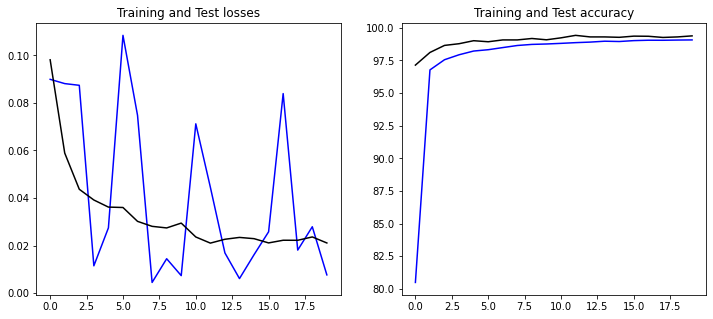

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.plot(train_losses, c='blue')
ax1.plot(test_losses, c='black')
ax1.title.set_text('Training and Test losses')

ax2.plot(train_acc, c='blue')
ax2.plot(test_acc, c='black')
ax2.title.set_text('Training and Test accuracy')